Testing validation methods for DCC detection

Primarily using lightning data, also using radar for cores

In [1]:
import os
import sys
import inspect
import itertools

import numpy as np
from numpy import ma
import pandas as pd
import xarray as xr
import cv2 as cv
from scipy import ndimage as ndi
from datetime import datetime, timedelta
from dateutil.parser import parse as parse_date

import matplotlib.pyplot as plt
from matplotlib import animation
import cartopy.crs as ccrs
from skimage.color import label2rgb
from matplotlib.colors import to_rgb
from IPython.display import HTML, Image, display

# code from https://stackoverflow.com/questions/279237/import-a-module-from-a-relative-path?lq=1#comment15918105_6098238 to load a realitive folde from a notebook
# realpath() will make your script run, even if you symlink it :)
cmd_folder = os.path.realpath(os.path.abspath(os.path.split(inspect.getfile( inspect.currentframe() ))[0]))
if cmd_folder not in sys.path:
    sys.path.insert(0, cmd_folder)

from utils import io, abi
from utils.flow import Flow
from utils import legacy_flow as lf

In [2]:
# Get pre-computed DCC detection and labels
save_path = './test_watershed2.nc'
dataset = xr.open_dataset(save_path)
dataset

<xarray.Dataset>
Dimensions:          (t: 96, x: 250, y: 250)
Coordinates:
    y_image          float32 ...
    x_image          float32 ...
  * t                (t) datetime64[ns] 2018-06-19T16:03:43.239603968 ... 201...
  * y                (y) float32 0.091812 0.091756 ... 0.077924006 0.077868
  * x                (x) float32 -0.028531998 -0.028476 ... -0.014587998
Data variables:
    inner_watershed  (t, y, x) bool ...
    inner_labels     (t, y, x) int64 ...
    outer_watershed  (t, y, x) bool ...
    outer_labels     (t, y, x) int64 ...
    wvd_diff         (t, y, x) float32 ...
    x_flow_for       (t, y, x) float32 ...
    x_flow_back      (t, y, x) float32 ...
    y_flow_for       (t, y, x) float32 ...
    y_flow_back      (t, y, x) float32 ...

In [3]:
# Get GOES-16 ABI data
goes_data_path = './data/GOES16'
os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = '/Users/jonesw/Downloads/dcc-detect-4e11a4adbc07.json'
start_date = datetime(2018,6,19,16)
days = timedelta(days=0.33)
dates = pd.date_range(start_date, start_date+days, freq='H', closed='left').to_pydatetime()
abi_files = list(sum([sorted(io.find_abi_files(date, satellite=16, product='MCMIP', view='C', mode=3, 
                                        save_dir=goes_data_path, 
                                        replicate_path=True, check_download=True, 
                                        n_attempts=1, download_missing=True))
                  for date in dates],[]))
             

abi_files = {io.get_goes_date(i):i for i in abi_files}
abi_dates = list(abi_files.keys())
len(abi_files)


96

In [5]:
# Get regridded validation data files
regrid_files = ['./data/regrid/old/regrid_%s.nc' % (date.strftime('%Y%m%d_%H0000')) for date in dates]
grid_ds = xr.open_mfdataset(regrid_files, concat_dim='t', combine='nested')
grid_ds

<xarray.Dataset>
Dimensions:     (t: 96, x: 250, y: 250)
Coordinates:
    y_image     float32 0.08624
    x_image     float32 -0.03136
  * x           (x) float32 -0.028531998 -0.028476 ... -0.014643997 -0.014587998
  * y           (y) float32 0.091812 0.091756 0.0917 ... 0.077924006 0.077868
  * t           (t) datetime64[ns] 2018-06-19T16:03:43.239603968 ... 2018-06-...
Data variables:
    glm_freq    (t, y, x) float64 dask.array<chunksize=(12, 250, 250), meta=np.ndarray>
    radar_ref   (t, y, x) float64 dask.array<chunksize=(12, 250, 250), meta=np.ndarray>
    radar_mask  (t, y, x) bool dask.array<chunksize=(12, 250, 250), meta=np.ndarray>

In [7]:
inner_watershed = dataset.inner_watershed.data
outer_watershed = dataset.outer_watershed.data

/Users/jonesw/opt/anaconda3/envs/flow_dev2/lib/python3.7/site-packages/cartopy/mpl/geoaxes.py:1478: UserWarning: No contour levels were found within the data range.
  result = matplotlib.axes.Axes.contour(self, *args, **kwargs)
/Users/jonesw/opt/anaconda3/envs/flow_dev2/lib/python3.7/site-packages/cartopy/mpl/geoaxes.py:1478: UserWarning: No contour levels were found within the data range.
  result = matplotlib.axes.Axes.contour(self, *args, **kwargs)


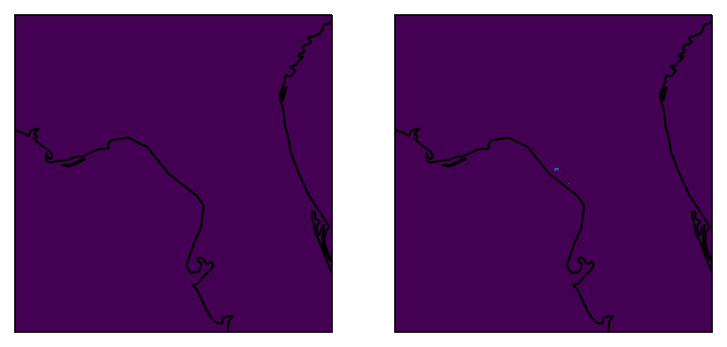

In [9]:
# Animated plot of watershedded regions over validation data
ds_slice = {'x':slice(1300,1550), 'y':slice(650,900)}
goes_ds = xr.open_dataset(list(abi_files.values())[0]).isel(ds_slice)

img_proj = ccrs.Geostationary(satellite_height=goes_ds.goes_imager_projection.perspective_point_height,
                              central_longitude=goes_ds.goes_imager_projection.longitude_of_projection_origin,
                              sweep_axis=goes_ds.goes_imager_projection.sweep_angle_axis)
h = goes_ds.goes_imager_projection.perspective_point_height
img_extent=(goes_ds.x[0]*h, goes_ds.x[-1]*h, goes_ds.y[-1]*h, goes_ds.y[0]*h)
fig = plt.figure(dpi=150)
ax1 = plt.subplot(1,2,1,projection=img_proj)
ax1.coastlines(resolution='50m', color='black', linewidth=1)
ax2 = plt.subplot(1,2,2,projection=img_proj)
ax2.coastlines(resolution='50m', color='black', linewidth=1)

i = 0
img1 = ax1.imshow(grid_ds.glm_freq[i], vmin=0, vmax=5, 
                extent=img_extent)
c11 = [ax1.contour(*np.meshgrid(goes_ds.x*h, goes_ds.y*h), 
                inner_watershed[i], [0.5], colors=['red'])]
c21 = [ax1.contour(*np.meshgrid(goes_ds.x*h, goes_ds.y*h), 
                outer_watershed[i], [0.5], colors=['blue'])]

img2 = ax2.imshow(grid_ds.radar_ref[i], vmin=0, vmax=40, 
                extent=img_extent)
c12 = [ax2.contour(*np.meshgrid(goes_ds.x*h, goes_ds.y*h), 
                inner_watershed[i], [0.5], colors=['red'])]
c22 = [ax2.contour(*np.meshgrid(goes_ds.x*h, goes_ds.y*h), 
                outer_watershed[i], [0.5], colors=['blue'])]


def init():
    return img1, c11, c21, img2, c12, c22

def animate(i):
    img1.set_data(grid_ds.glm_freq[i])
    img2.set_data(grid_ds.radar_ref[i])
    for coll in c11[0].collections:
        coll.remove()
    c11[0] = ax1.contour(*np.meshgrid(goes_ds.x*h, goes_ds.y*h), 
                inner_watershed[i], [0.5], colors=['red'])
    for coll in c21[0].collections:
        coll.remove()
    c21[0] = ax1.contour(*np.meshgrid(goes_ds.x*h, goes_ds.y*h), 
                outer_watershed[i], [0.5], colors=['blue'])
    for coll in c12[0].collections:
        coll.remove()
    c12[0] = ax2.contour(*np.meshgrid(goes_ds.x*h, goes_ds.y*h), 
                inner_watershed[i], [0.5], colors=['red'])
    for coll in c22[0].collections:
        coll.remove()
    c22[0] = ax2.contour(*np.meshgrid(goes_ds.x*h, goes_ds.y*h), 
                outer_watershed[i], [0.5], colors=['blue'])
    return img1, c11, c21, img2, c12, c22
    

anim = animation.FuncAnimation(fig, animate, init_func=init, frames=48, 
                               interval=50, blit=False)


In [11]:
import matplotlib
matplotlib.rcParams['animation.embed_limit']=100

In [12]:
HTML(anim.to_jshtml())

/Users/jonesw/opt/anaconda3/envs/flow_dev2/lib/python3.7/site-packages/cartopy/mpl/geoaxes.py:1478: UserWarning: No contour levels were found within the data range.
  result = matplotlib.axes.Axes.contour(self, *args, **kwargs)
/Users/jonesw/opt/anaconda3/envs/flow_dev2/lib/python3.7/site-packages/cartopy/mpl/geoaxes.py:1478: UserWarning: No contour levels were found within the data range.
  result = matplotlib.axes.Axes.contour(self, *args, **kwargs)
/Users/jonesw/opt/anaconda3/envs/flow_dev2/lib/python3.7/site-packages/cartopy/mpl/geoaxes.py:1478: UserWarning: No contour levels were found within the data range.
  result = matplotlib.axes.Axes.contour(self, *args, **kwargs)
/Users/jonesw/opt/anaconda3/envs/flow_dev2/lib/python3.7/site-packages/cartopy/mpl/geoaxes.py:1478: UserWarning: No contour levels were found within the data range.
  result = matplotlib.axes.Axes.contour(self, *args, **kwargs)
/Users/jonesw/opt/anaconda3/envs/flow_dev2/lib/python3.7/site-packages/cartopy/mpl/geoax